# Классификация рукописных цифр MNIST

In [1]:
import torch
import random
import numpy as np

import torchvision.datasets

from tqdm import tqdm
import gc

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 38728651.86it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1054435.80it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8280917.90it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2216208.56it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

len(y_train), len(y_test)

(60000, 10000)

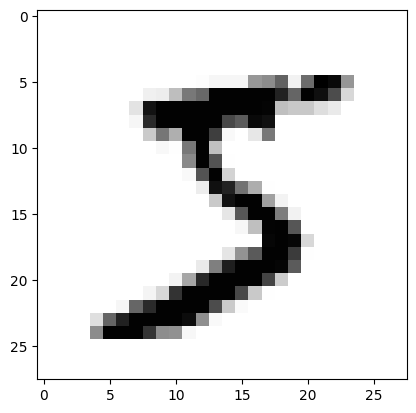

tensor(5)


In [4]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :], cmap="Greys")
plt.show()
print(y_train[0])

In [5]:
print(X_train.shape, X_test.shape)

# Добавим ось каналов
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

X_train.shape, X_test.shape

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


(torch.Size([60000, 1, 28, 28]), torch.Size([10000, 1, 28, 28]))

Далее реализуем модернизированную архитектуру LeNet5

In [34]:
class LeNetMod(torch.nn.Module):
    def __init__(self):
        super(LeNetMod, self).__init__()

        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=12, kernel_size=3, padding=1)
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(
            in_channels=12, out_channels=24, kernel_size=3, padding=1)
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = torch.nn.Conv2d(
            in_channels=24, out_channels=48, kernel_size=3, padding=1)
        self.act3  = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = torch.nn.Conv2d(
            in_channels=48, out_channels=96, kernel_size=3, padding=1)
        self.act4  = torch.nn.ReLU()
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=1)

        self.fc1   = torch.nn.Linear(384, 128)
        self.act5  = torch.nn.ReLU()

        self.fc2   = torch.nn.Linear(128, 64)
        self.act6  = torch.nn.ReLU()

        self.fc3   = torch.nn.Linear(64, 10)

    def forward(self, x):

        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.act4(x)
        x = self.pool4(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act5(x)
        x = self.fc2(x)
        x = self.act6(x)
        x = self.fc3(x)

        return x

In [48]:
torch.cuda.empty_cache()
gc.collect()

6063

In [50]:
lenet = LeNetMod()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet = lenet.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet.parameters(), lr=1.0e-4)

In [51]:
batch_size = 128

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in tqdm(range(100)):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):  
        optimizer.zero_grad()
        lenet.train()

        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        preds = lenet.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()

    lenet.eval()
    test_preds = lenet.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())

    test_accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(test_accuracy)

del lenet

100%|██████████| 100/100 [02:35<00:00,  1.55s/it]


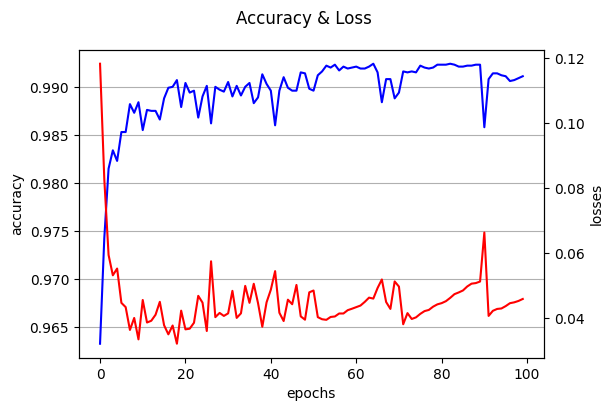

In [52]:
    _, ax1 = plt.subplots(sharex=True, figsize=(6, 4))
    plt.suptitle('Accuracy & Loss')
    ax1.plot(test_accuracy_history, color='b')
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('accuracy')
    plt.grid(axis='y')
    ax2 = ax1.twinx()
    ax2.plot(test_loss_history, color='r')
    ax2.set_ylabel('losses')
    plt.show()

In [65]:
print(f'Max Test Accuracy: {round(max(test_accuracy_history).item(), 4)}')

Max Test Accuracy: 0.9924
